In [1]:
#default_exp anime.dataloader

In [2]:
import torch.nn as nn

In [3]:
#export
import pandas as pd
from pathlib import Path
import json
from functools import partial
from PIL import Image
import numpy as np
from itertools import chain
from fastai2.torch_basics import *
from fastai2.layers import *
from fastai2.data.all import *
from fastai2.data.block import *
from fastai2.optimizer import *
from fastai2.learner import *
from fastai2.metrics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from anime.ugatit import *
from fastai2.callback.wandb import WandbCallback
import wandb
from fastai2.fp16_utils import convert_module
from anime.ugatit_networks import ILN,adaILN
from fastai2.callback.fp16 import _copy_state
from torch.autograd import Variable
import gc
import math

In [4]:
from torch.nn.parallel import DistributedDataParallel, DataParallel

In [5]:
defaults.use_cuda=True 
path=Path("/home/fast/.fastai/data/danbooru2018")
meta_path=path/'metadata/2018000000000016'
portraits=pd.read_pickle(path/'portraits')
selfie_path=Path('/home/fast/.fastai/data/Selfie-dataset')
self_txt= selfie_path/'selfie_dataset.txt'
self_txt.exists()
attrs='image_name popularity partial_faces is_female baby child teenager youth middle_age senior white black asian oval_face round_face heart_face smiling mouth_open frowning wearing_glasses wearing_sunglasses wearing_lipstick tongue_out duck_face black_hair blond_hair brown_hair red_hair curly_hair straight_hair braid_hair showing_cellphone using_earphone using_mirror braces wearing_hat harsh_lighting dim_lighting'.split()
img_size=256 #needs to be >96 oherwise loss is nan
bs=3 #needs to be >=3 otherwise gradient overflow

In [6]:
lr=0.0001
wd=0.1

In [7]:
data_stats={'selfie_means':torch.Tensor([143.81911227601947, 119.46716940677527, 113.92494676532168]),
 'selfie_stds':torch.Tensor([67.72407215465199, 64.41496156519109, 52.516515323610015]),
 'anime_means':torch.Tensor([173.24273681640625, 155.69161987304688, 135.62557983398438]),
 'anime_stds':torch.Tensor([51.790767669677734, 48.620208740234375, 48.380496978759766])}
data_stats={'selfie_means':(data_stats['selfie_means']+data_stats['anime_means'])/2,
 'selfie_stds':(data_stats['selfie_stds']+data_stats['anime_stds'])/2,
 'anime_means':(data_stats['selfie_means']+data_stats['anime_means'])/2,
 'anime_stds':(data_stats['selfie_stds']+data_stats['anime_stds'])/2}

## Tag comparison

In [8]:
def getSelfiePath(df,dir,i):
    dft=df.iloc[[i]]
    path=dir/((dft['image_name']).values[0]+'.jpg')
    return (dft.values,path)
def getImagePath(df,dir,i):
    dft=df.iloc[[i]]
    path=dir/'512px'/(dft['directory']+'/'+dft['file']).values[0]
    return (dft.tags.values[0],path)

In [63]:
class DSList():
    def __init__(self,name='selfie2anime'):
        self.name=name
    def __call__(self):
        if(self.name=='selfie2anime'):
            return self._selfie2anime()
        elif(self.name=='_danbooru'):
            return self._danbooru()
        elif(self.name=='selfie2animeTest'):
            return self._selfie2animeTest()
    def _danbooru(self):
        def txt_to_path(img,dir=dir,ext='.jpg'):
            return dir/(img+ext)
        selfies=pd.read_pickle(selfie_path/'selfies')
        selfie_imgs=L(list(selfies['image_name'].apply(partial(txt_to_path,dir=selfie_path/'images'))))
        f=partial(txt_to_path,dir=path/'512px',ext='')
        locs=portraits['directory']+'/'+portraits['file']
        anime_imgs=L(list(locs.apply(f)))
        return selfie_imgs,anime_imgs
    def _selfie2anime(self):
        selfie_imgs=L(Path("/home/fast/.fastai/data/selfie2anime/trainA").ls())
        anime_imgs=L(Path("/home/fast/.fastai/data/selfie2anime/trainB").ls())
        return selfie_imgs,anime_imgs
    def _selfie2animeTest(self):
        selfie_imgs=L(Path("/home/fast/.fastai/data/selfie2anime/testA").ls())
        anime_imgs=L(Path("/home/fast/.fastai/data/selfie2anime/testB").ls())
        return selfie_imgs,anime_imgs
selfie_imgs,anime_imgs=DSList()()
len(anime_imgs),len(selfie_imgs)

(3400, 3400)

In [11]:
denorm = lambda prefix,x: x*data_stats[prefix+'_stds'][...,None,None]/255+data_stats[prefix+'_means'][...,None,None]/255
class CycleImage(Tuple):
    def toTensor(self):
        selfie,anime = self
        return torch.cat([selfie,anime], dim=2)
    def show(self, ctx=None, **kwargs): 
        img=self.toTensor().detach().cpu()
        print(img.shape)
        selfie=denorm('selfie',img[:,:,0:img_size])
        anime=denorm('anime',img[:,:,img_size:])
        return show_image(torch.cat([selfie,anime], dim=2),  ctx=ctx)

In [12]:
class CyclePair(Transform):
    def __init__(self,bItems):
        self.small = bItems 
        self.assoc = self
        
    def encodes(self,i):
        "x: tuple of `i`th image and a random image from same or different class; y: True if same class"
        return CycleImage(i, random.choice(self.small))

In [14]:
class ToTensorTuple(Transform):
    "Convert item to appropriate tensor class"
    order = 15
@ToTensorTuple
def encodes(self, o:CycleImage): return TensorImage(image2byte(o))

In [15]:
def resized_image(fn:Path, sz=128):
    x = Image.open(fn).resize((sz,sz))
    x = array(x)
    if x.ndim==3:
        return tensor(x).permute(2,0,1).float()/255.
    elif x.ndim==2:
        return tensor(x)[None].repeat(3,1,1).float()/255.
OpenAndResize = Transform(partial(resized_image,sz=img_size))

In [16]:
tfm=Pipeline([CyclePair(anime_imgs), OpenAndResize, IntToFloatTensor(div=False)])

In [17]:
selfie_norm = lambda stats,x: (255*x-unsqueeze(stats['selfie_means'],n=2)[None])/unsqueeze(stats['selfie_stds'],n=2)[None]
anime_norm = lambda stats,x: (255*x-unsqueeze(stats['anime_means'],n=2)[None])/unsqueeze(stats['anime_stds'],n=2)[None]

In [18]:
class ListofTransformsforTuple(Transform):
    "Convert item to appropriate tensor class"
    order = 60
    def __init__(self, transforms, stats):
        self.transforms=transforms
        self.stats=to_device(stats)
    def encodes(self, o): 
        if(o.shape[-3:]==torch.Size([1, 1, 1])): #don't transform the labels
            return o
        o=TensorImage(o)
        with torch.no_grad():
            for t in self.transforms:
                o=t(o)
            o = selfie_norm(to_device(self.stats,device=o.device),o)
        return o
transforms=aug_transforms(do_flip=True, flip_vert=False, max_rotate=10., max_zoom=4.0, max_lighting=0.2,max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None,size=None, mode='bilinear', pad_mode=PadMode.Reflection)
transforms=ListofTransformsforTuple(transforms, data_stats)

In [19]:
after_batch=[transforms]

In [20]:
class NoopTensor(Transform):
    def encodes(self, x): return CycleImage(torch.Tensor([[[0]]]),torch.Tensor([[[0]]]))

In [21]:
tfm2=Pipeline([NoopTensor()])

In [59]:
val_path=selfie_imgs[0].parent
val = ['female_10686.jpg','female_10367.jpg','female_30988.jpg','female_8194.jpg','female_18724.jpg','female_10087.jpg','female_27647.jpg','female_13409.jpg','female_20608.jpg','female_26279.jpg','female_7103.jpg''female_10615.jpg','female_25884.jpg','female_31235.jpg','female_28991.jpg','female_9936.jpg','female_33285.jpg','female_33491.jpg','female_1597.jpg', 'female_13893.jpg', 'female_26481.jpg', 'female_32384.jpg', 'female_18827.jpg', 'female_19176.jpg', 'female_6150.jpg','female_1487.jpg', 'female_13914.jpg', 'female_29264.jpg', 'female_17571.jpg', 'female_32817.jpg', 'female_7374.jpg', 'female_16798.jpg', 'female_21739.jpg', 'female_22605.jpg', 'female_21305.jpg', 'female_12988.jpg', 'female_4297.jpg', 'female_9025.jpg', 'female_13560.jpg', 'female_31712.jpg', 'female_1177.jpg', 'female_13787.jpg', 'female_11117.jpg', 'female_10664.jpg', 'female_17134.jpg', 'female_16420.jpg', 'female_95.jpg', 'female_15298.jpg', 'female_32776.jpg', 'female_9353.jpg', 'female_22181.jpg', 'female_32015.jpg', 'female_27565.jpg', 'female_19001.jpg', 'female_8955.jpg', 'female_33094.jpg', 'female_7486.jpg', 'female_32167.jpg', 'female_28716.jpg', 'female_6519.jpg', 'female_4339.jpg', 'female_24557.jpg', 'female_20786.jpg', 'female_26695.jpg', 'female_25546.jpg', 'female_15424.jpg', 'female_711.jpg', 'female_31004.jpg', 'female_9440.jpg', 'female_22912.jpg', 'female_2754.jpg', 'female_24839.jpg', 'female_12741.jpg', 'female_9480.jpg', 'female_15677.jpg', 'female_23557.jpg', 'female_3006.jpg', 'female_29858.jpg', 'female_8664.jpg', 'female_16808.jpg', 'female_32694.jpg', 'female_5019.jpg', 'female_15584.jpg', 'female_32256.jpg', 'female_5747.jpg', 'female_22101.jpg', 'female_4115.jpg', 'female_20185.jpg', 'female_25131.jpg', 'female_31061.jpg', 'female_2546.jpg', 'female_30868.jpg', 'female_17341.jpg', 'female_9415.jpg', 'female_14142.jpg', 'female_11470.jpg', 'female_683.jpg', 'female_3433.jpg', 'female_19286.jpg', 'female_30070.jpg']

In [23]:
selfieL=0
selfieL=len(selfie_imgs)-100 if selfieL<3 or selfieL>len(selfie_imgs)-100 else selfieL
selfie_sample=selfie_imgs.filter(lambda s:s.name in val,negate=True)
selfie_sample=selfie_sample.shuffle()[0:selfieL]
selfie_sample=selfie_sample+map(lambda v:val_path/v,val)
tfmDs=Datasets(selfie_sample,[tfm,tfm2],splits=[[selfie.name not in val for selfie in selfie_sample],[selfie.name in val for selfie in selfie_sample]])

In [24]:
dl=TfmdDL(tfmDs,bs=bs, shuffle=False, num_workers=8,after_batch=after_batch)

In [25]:
dls=tfmDs.dataloaders(bs=bs,val_bs=1,after_batch=after_batch, num_workers=0)

In [26]:
@typedispatch
def show_batch(x, y, samples, ctxs=None, max_n=9, **kwargs):
    if ctxs is None: ctxs = Inf.nones
    for i in range_of(samples[0]):
        [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i),ctxs,range(max_n))]
    return ctxs

In [27]:
dl.one_batch()

((TensorImage([[[[ 1.5897,  1.5840,  1.5783,  ...,  1.5641,  1.5641,  1.5643],
            [ 1.5849,  1.5792,  1.5734,  ...,  1.5641,  1.5641,  1.5647],
            [ 1.5801,  1.5744,  1.5686,  ...,  1.5641,  1.5641,  1.5649],
            ...,
            [-1.4161, -1.2069, -1.1113,  ...,  1.6061,  1.6119,  1.6110],
            [-1.4300, -1.2208, -1.0995,  ...,  1.6057,  1.6115,  1.6114],
            [-1.4459, -1.2441, -1.1085,  ...,  1.6053,  1.6111,  1.6118]],
  
           [[ 1.8453,  1.8447,  1.8442,  ...,  1.9537,  1.9537,  1.9539],
            [ 1.8395,  1.8390,  1.8384,  ...,  1.9537,  1.9537,  1.9543],
            [ 1.8338,  1.8332,  1.8327,  ...,  1.9537,  1.9537,  1.9545],
            ...,
            [-0.9590, -0.7436, -0.6550,  ...,  1.4316,  1.4255,  1.4194],
            [-0.9730, -0.7576, -0.6403,  ...,  1.4321,  1.4260,  1.4199],
            [-0.9891, -0.7815, -0.6476,  ...,  1.4325,  1.4264,  1.4203]],
  
           [[ 1.5821,  1.6310,  1.6800,  ...,  1.6893,  1.6893,  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 512])
torch.Size([3, 256, 512])
torch.Size([3, 256, 512])
torch.Size([1, 1, 2])
torch.Size([1, 1, 2])
torch.Size([1, 1, 2])


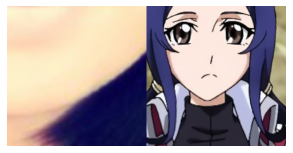

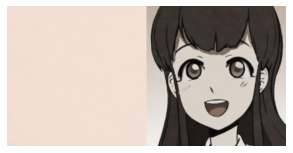

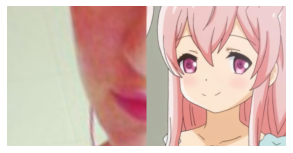

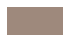

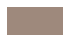

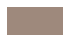

In [28]:
#import pdb; pdb.set_trace()
dl.show_batch()

torch.Size([3, 256, 512])
torch.Size([1, 1, 2])


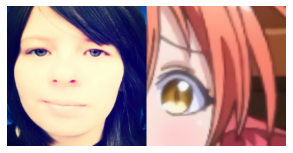

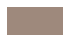

In [29]:
CycleImage(dl._pre_show_batch(dl.one_batch(), max_n=9)[0][0][0],dl._pre_show_batch(dl.one_batch(), max_n=9)[0][1][0]).show()
CycleImage(dl._pre_show_batch(dl.one_batch(), max_n=9)[1][0][0],dl._pre_show_batch(dl.one_batch(), max_n=9)[1][1][0]).show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


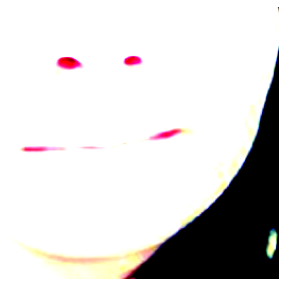

In [30]:
show_image(dl._pre_show_batch(dl.one_batch(), max_n=9)[0][0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


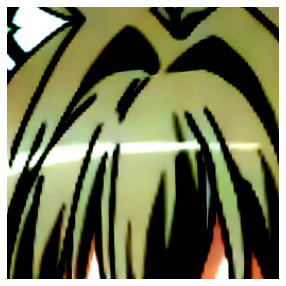

In [31]:
show_image(dls.valid.one_batch()[0][1][0])

In [32]:
ugatit=UGATIT()
ugatit
ugatit.img_size=img_size
ugatit.build_model()

In [33]:
noop_loss = lambda x: torch.FloatTensor([0])

In [34]:
class GANOptimizer(object):
    def __init__(self, gen_optim,disc_optim,params,**kwargs):
        gen_params,disc_params=params
        #might want to try lower lr for the generator
        self.gen_optim,self.disc_optim=gen_optim(gen_params,**kwargs),disc_optim(disc_params,**kwargs)
        self.optimizing_gen=True
    def __getattr__(self, item):
        opt= self.gen_optim if(self.optimizing_gen) else self.disc_optim
        return getattr(opt, item)
    def zero_grad(self):
        self.gen_optim.zero_grad()
        self.disc_optim.zero_grad()
    def state_dict(self):
        gs = self.gen_optim.state_dict()
        ds = self.disc_optim.state_dict()
        return {'hypers':{
                    'gen':gs['hypers'],
                    'disc':ds['hypers']},
                'state':{
                    'gen':gs['state'],
                    'disc':ds['state']}}
    def load_state_dict(self, sdict):
        self.gen_optim.load_state_dict({'hypers': sdict['param_groups']['gen'],'state':sdict['state']['gen']})
        self.disc_optim.load_state_dict({'param_groups': sdict['param_groups']['disc'],'state':sdict['state']['disc']})
        
#TODO unable to run one_batch twice without two after_batch calls
#TODO discriminator probably doesn't need gradients from generator, check cycle gan code/paper
class Switch(Callback):
    toward_end=True
    def begin_epoch(self):
        self.learn.disc_pass=False #TODO too many (not disc_pass), switch to gen_pass?!?
        self.model.optimizing_gen= not self.learn.disc_pass
        if(hasattr(self, 'gan_losses')):
            self.learn.loss_func=self.gan_losses[self.learn.disc_pass]
        self.opt.zero_grad()
    def begin_batch(self):
        if(not hasattr(self, 'gan_losses')):
            self.gan_losses=self.loss_func
            self.learn.loss_func=self.gan_losses[self.learn.disc_pass]
        self.opt.zero_grad()
        clear_grads(self.model.parameters())
        self.learn.loss_func=self.gan_losses[self.learn.disc_pass]
    def after_batch(self):
        if(getattr(self.learn,'overflow',False)):
            self.learn.overflow=False
            if(self.learn.disc_pass):
                self.one_batch(self.iter,self.learn.dls.train.one_batch())
            return
        self._switch()
        
    def after_epoch(self):
        self.loss_func=self.gan_losses
    
    def _switch(self):
        if(self.learn.training): self.learn.disc_pass=not self.learn.disc_pass
        self.model.optimizing_gen= not self.learn.disc_pass
        self.opt.optimizing_gen= not self.learn.disc_pass
        self.opt.zero_grad()
        self.learn.loss_func=self.gan_losses[self.learn.disc_pass]
        if(self.learn.disc_pass):
            self.one_batch(self.iter,(learner.xb[0],(CycleImage(torch.Tensor([[[[0]]]]).cuda(),torch.Tensor([[[[0]]]]).cuda()))))
        
class RhoClipper(Callback):
    run_after=Switch
    toward_end=True
    def after_batch(self):
        self.model.models['GA2B'].apply(ugatit.Rho_clipper)
        self.model.models['GB2A'].apply(ugatit.Rho_clipper)
class PrintLoss(Callback):
    def after_loss(self):
        if(self.iter%100==0):    
            print('batch: #'+str(self.iter)+'/'+str(self.n_iter)+'/'+str(self.epoch))
            if(self.learn.disc_pass):
                print('loss Disc: '+str(self.loss.item()))
            else:
                print('loss Gen: '+str(self.loss.item()))
    def begin_batch(self):
        if(self.iter%100==0):
            print('begin batch - batch: #'+str(self.iter)+'/'+str(self.n_iter)+'/'+str(self.epoch))
            print('memory_allocated()',torch.cuda.memory_allocated())
            print('max_memory_allocated()',torch.cuda.max_memory_allocated())
    def after_pred(self):
        if(self.iter%100==0):
            print('after pred- batch: #'+str(self.iter)+'/'+str(self.n_iter)+'/'+str(self.epoch))
            print('memory_allocated()',torch.cuda.memory_allocated())
            print('max_memory_allocated()',torch.cuda.max_memory_allocated())
    def after_backward(self):
        if(self.iter%100==0):
            print('batch: #'+str(self.iter)+'/'+str(self.n_iter)+'/'+str(self.epoch))
            print('memory_allocated()',torch.cuda.memory_allocated())
            print('max_memory_allocated()',torch.cuda.max_memory_allocated())

            for obj in gc.get_objects():
                try:
                    if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                        if obj.device==default_device() and obj.dtype==torch.float:
                            print(type(obj), obj.size(), obj.device, obj.dtype)
                except:
                    pass
class LinearDecreaseLR(Callback):
    def __init__(self,start_epoch=0,end_epoch=None):
        store_attr(self,"start_epoch,end_epoch")
    def begin_fit(self):
        self.LDmax_lr=self.lr
    def end_fit(self):
        self.lr=self.LDmax_lr
    def begin_batch(self):
        end_epoch = self.end_epoch if(self.end_epoch) else self.n_epoch
        current_iter=(self.epoch+self.start_epoch)*self.n_iter+self.iter
        run_length=end_epoch*self.n_iter
        half_run=run_length // 2
        self.LDlr=self.LDmax_lr
        if current_iter > half_run:
            self.LDlr = (run_length-current_iter)*self.LDmax_lr/(run_length-half_run)
        #elif current_iter < half_run/2:
        #    self.lr = self.max_lr*(current_iter+1)/(half_run/2+1)
        else:
            self.LDlr = self.LDmax_lr
        self.opt.set_hyper('lr',self.LDlr)
        
class SameXbYb(Callback):
    def begin_batch(self):
        self.learn.xb=(self.learn.xb[0],to_device(self.learn.xb,torch.device('cuda',index=1))[0])
    def after_pred(self):
        self.learn.yb=to_float(self.learn.xb)
class CachedMemoryDebug(Callback):
    def after_batch(self):
        print(torch.cuda.memory_cached(device=torch.device('cuda',index=0))
              ,torch.cuda.memory_cached(device=torch.device('cuda',index=1)))
class OptimizedOptimizer(Optimizer):
    #Changing order to guarantee order of params in optimizer smallest to largest. 
    #This allows params to be cleared before getting to largest param update. 
    def all_params(self, n=slice(None), with_grad=False, sort_key=lambda p: np.prod(p[0].shape)):
        res = super().all_params(n=n, with_grad=with_grad)
        res.sort(sort_key)
        return res
    def zero_grad(self, clear=False):
        for p,*_ in self.all_params(with_grad=True):
            p.grad.detach_()
            p.grad.zero_()
            if(clear): del p.grad
def zero_grad(p, **kwargs):
    "Register the number of steps done in `state` for `p`"
    p.grad.detach_()
    p.grad.zero_()
    del p.grad
    return {}
def zero_Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-5, wd=0., decouple_wd=True):
    "A `Optimizer` for Adam with `lr`, `mom`, `sqr_mom`, `eps` and `params`"
    cbs = [weight_decay]
    cbs += [partial(average_grad, dampening=True), average_sqr_grad, step_stat, adam_step,zero_grad]
    return OptimizedOptimizer(params, cbs, lr=lr, mom=mom, sqr_mom=sqr_mom, eps=eps, wd=wd)
def clear_grads(params):
    for p in params:
        if(is_listy(p)):
            clear_grads(p)
        elif(p.grad is not None):
            del p.grad

In [35]:
@typedispatch
def wandb_process(x:CycleImage, y:CycleImage, samples, outs):
    "Process `sample` and `out` depending on the type of `x/y`"
    res = []
    for s,o in zip(samples, outs):
        img = TensorImage(s[0].toTensor()[0])
        #db.valid_dl.decode(s)
        res.append(wandb.Image(img, caption='Input data', grouping=3))
        for t, capt in ((o[0], "Prediction"), (s[1], "Ground Truth")):
            # Resize plot to image resolution (from https://stackoverflow.com/a/13714915)
            my_dpi = 100
            fig = plt.figure(frameon=False, dpi=my_dpi)
            h, w = img.shape[:2]
            fig.set_size_inches(w / my_dpi, h / my_dpi)
            ax = plt.Axes(fig, [0., 0., 1., 1.])
            ax.set_axis_off()
            fig.add_axes(ax)
            # Superimpose label or prediction to input image
            ax = img.show(ctx=ax)
            #import pdb; pdb.set_trace()
            ax = t.show(ctx=ax)
            res.append(wandb.Image(fig, caption=capt))
            plt.close(fig)
    return res

In [36]:
class MetricRecorder(Callback):
    def __init__(self):
        super().__init__()
        self.remove_on_fetch=True
    def after_batch(self):
        mets = self.recorder._train_mets if self.training else self.recorder._valid_mets
        self.learn.metric_values=dict([(met.name, met.value) for met in mets])

In [37]:
class Conditional_Loss(AvgSmoothLoss):
    def __init__(self, f=lambda x:True,name='None',beta=0.98,): 
        super(Conditional_Loss,self).__init__(beta)
        self.f=f
        self.metric_name=name
    def accumulate(self, learn):
        if(self.f(learn)):
            super().accumulate(learn)
            
            setattr(learn, self.metric_name, self.value)
    @property
    def name(self):
        return self.metric_name

In [38]:
#https://github.com/NVIDIA/apex/blob/03a25ba8a61d15a503405ef4bbda83724bb531b2/apex/fp16_utils/fp16util.py
# had to edit due to custom normalization layers
def convert_module_alt(module, dtype):
    """
    Converts a module's immediate parameters and buffers to dtype.
    """
    for param in module.parameters(recurse=False):
        if param is not None:
            if param.data.dtype.is_floating_point:
                param.data = param.data.to(dtype=dtype)
            if param._grad is not None and param._grad.data.dtype.is_floating_point:
                param._grad.data = param._grad.data.to(dtype=dtype)
    spectral_norm_buffers=filter(lambda b:b[0] in ('weight_u','weight_v','weight_orig'),module.named_buffers(recurse=False))
    spectral_norm_buffers=list(map(lambda b: b[1],spectral_norm_buffers))
    spectral_norm_buffers=[]
    for buf in module.buffers(recurse=False):
        if buf is not None and buf.data.dtype.is_floating_point and 0==len(list(filter(lambda b:b.shape==buf.shape and torch.all(torch.eq(b, buf)),spectral_norm_buffers))):
            buf.data = buf.data.to(dtype=dtype)
def convert_network(network, dtype):
    """
    Converts a network's parameters and buffers to dtype.
    """
    for module in network.modules():
        if isinstance(module, torch.nn.modules.batchnorm._BatchNorm) and module.affine is True:
            continue
        if isinstance(module, (ILN,adaILN,nn.InstanceNorm2d,nn.LayerNorm)):
            continue
        convert_module_alt(module, dtype)
        if isinstance(module, torch.nn.RNNBase) or isinstance(module, torch.nn.modules.rnn.RNNBase):
            module.flatten_parameters()
    return network

In [39]:
def master_params_to_model_params(model_params, master_params, flat_master=False):
    """
    Copy master parameters to model parameters.
    Args:
        model_params:  List of model parameters created by :func:`prep_param_lists`.
        master_params:  List of FP32 master parameters created by :func:`prep_param_lists`.  If ``master_params`` was created with ``flat_master=True``, ``flat_master=True`` should also be supplied to :func:`master_params_to_model_params`.
    """
    for model, master in zip(model_params, master_params):
        model.data=master.data.clone()

In [40]:
def to_model_params(model_pgs, master_pgs, flat_master:bool=False)->None:
    for (model_params,master_params) in zip(model_pgs,master_pgs):
        master_params_to_model_params(model_params, master_params, flat_master=flat_master)

In [41]:
def multi_model_params(models):
    ps=[]
    for m in models:
        ps+=[p for p in m.parameters() if p.requires_grad]
    return ps
def GAN_splitter(model):
    gen_params=itertools.chain(model.models['GA2B'].parameters(),model.models['GB2A'].parameters())
    disc_params=itertools.chain(model.models['DA'].parameters(),model.models['DB'].parameters(),model.models['LA'].parameters(),model.models['LB'].parameters())
    return (gen_params,disc_params)
class GANWandb(WandbCallback):
    run_before=Switch
    def after_batch(self):
        "Log hyper-parameters and training loss"
        g_scale,d_scale = (self.learn.mixed_precision_tuple.gloss_scale,self.learn.mixed_precision_tuple.dloss_scale) if(hasattr(self.learn,'mixed_precision_tuple')) else (1,1)
        if self.training and not self.learn.disc_pass:
            self._wandb_step += 1
            self._wandb_epoch += 1/self.n_iter
            hypers = {f'{k}G_{i}':v for i,h in enumerate(self.opt.hypers) for k,v in h.items()}
            wandb.log({'epoch': self._wandb_epoch,'loss': self.smooth_loss, **hypers, **self.learn.metric_values, 'loss_scaleG': g_scale}, step=self._wandb_step)
        elif self.training and self.learn.disc_pass:
            hypers = {f'{k}D_{i}':v for i,h in enumerate(self.opt.hypers) for k,v in h.items()}
            wandb.log({'epoch': self._wandb_epoch,'loss': self.smooth_loss, **hypers, **self.learn.metric_values, 'loss_scaleD': d_scale}, step=self._wandb_step)
    #Fixing memory usage
    def after_epoch(self):
        "Log validation loss and custom metrics & log prediction samples"
        # Correct any epoch rounding error and overwrite value
        self._wandb_epoch = round(self._wandb_epoch)
        wandb.log({'epoch': self._wandb_epoch}, step=self._wandb_step)
        # Log sample predictions
        if self.log_preds:
            b = self.valid_dl.one_batch()
            with torch.no_grad():
                self.learn.model.eval()
                self.learn.one_batch(0, b)
                self.learn.model.train()
            preds = getattr(self.loss_func, 'activation', noop)(self.pred)
            out = getattr(self.loss_func, 'decodes', noop)(preds)
            x,y,its,outs = self.valid_dl.show_results(b, out, show=False, max_n=self.n_preds)
            wandb.log({"Prediction Samples": wandb_process(x, y, its, outs)}, step=self._wandb_step)
        wandb.log({n:s for n,s in zip(self.recorder.metric_names, self.recorder.log) if n not in ['train_loss', 'epoch', 'time']}, step=self._wandb_step)
#targs_func = lambda b: np.resize(b[0][1].numpy(),[1,3,299,299])
#kid=KIDCallback(Tensor(array(list(map(targs_func,db.valid_dl)))))
#metrics=kid.kid
gen_loss=Conditional_Loss(lambda learn: not learn.disc_pass, name='Gloss_Metric')
disc_loss=Conditional_Loss(lambda learn: learn.disc_pass, name='Dloss_Metric')
#cycle_weight = 2.,identity_weight = 2.,cam_weight = 8.,adv_weight=1.
model=UgatitModel(ugatit.models,devices=[torch.device(type='cuda', index=0),torch.device(type='cuda', index=1)])
model=convert_network(model, dtype=torch.float16)
learner=Learner(dls,model,UGATITLoss(cycle_weight = 10,identity_weight = 10,cam_weight = 1000,adv_weight=1).losses,partial(GANOptimizer,zero_Adam,zero_Adam,wd=wd),lr,splitter=GAN_splitter,metrics=[gen_loss,disc_loss])
learner.add_cbs(L([Switch(),LinearDecreaseLR(start_epoch=280,end_epoch=300),RhoClipper(),SameXbYb()]))
#
#PrintLoss(),
#LinearDecreaseLR(),
#learner.load(path/'30_fp32_90x90_1_15',strict=False)
#rec=learner.cbs.filter(lambda f:f.name=='recorder')[0]
#learner.remove_cb(rec)
learner.add_cb(MetricRecorder())
learner.recorder.train_metrics=True
#learner.load('ugatitdoublesmall_80.pth',with_opt=True)

In [42]:
def zero_params(model_pgs):
    for model_params in model_pgs:
        for model in model_params:
            model.data.copy_(torch.zeros((1,1,1,1),device=model.data.device,dtype=model.data.dtype))

Try using just the generator, discriminator, and pre-trained GAN output. Loss function would be adverserial loss + MSE-ish loss with pre-trained GANs output. LR would have to decrease overtime and/or wight between adv loss and MSE loss would need to be more adverserial. 

In [43]:
def get_master(opt, flat_master=False, ): #device=cuda
    model_params = [[param for param in pg if param.requires_grad] for pg in opt.param_groups]
    if flat_master:
        master_params = []
        for pg in model_params:
            mp = parameters_to_vector([param.data.float() for param in pg])
            mp = nn.Parameter(mp, requires_grad=True)
            if mp.grad is None: mp.grad = mp.new(*mp.size())
            master_params.append([mp])
    else:
        master_params = [[nn.Parameter(param.data.float().detach(), requires_grad=True) for param in pg] for pg in model_params]
    return model_params, master_params

In [44]:
def pgs_to_device(pgs,device=default_device()):
    to_device = lambda p:p.to(device=device)
    return [list(map(to_device,pg)) for pg in pgs]

In [45]:
def clear_model_grads_to_master_grads(model_params, master_params):
    for model, master in zip(model_params, master_params):
        if model.grad is not None:
            if master.grad is None:
                master.grad = Variable(master.data.new(*master.data.size()))
            master.grad.data.copy_(model.grad.data)
            del model.grad
        else:
            master.grad = None

In [46]:
def clear_to_master_grads(model_pgs, master_pgs, flat_master=False):
    for (model_params,master_params) in zip(model_pgs,master_pgs):
        clear_model_grads_to_master_grads(model_params, master_params) #, flat_master=flat_master)

In [47]:
def find_overflow(ps):
    overflow=[]
    for n,p in ps:
        if p.grad is not None and test_overflow(p.grad.data): overflow.append((n,p.detach().size()))
    return overflow

In [48]:
class ModelToHalfAdaLIN(Callback):
    "Use with MixedPrecision callback (but it needs to run at the very beginning)"
    run_before=TrainEvalCallback
    #def begin_fit(self): 
        #self.learn.model.to(torch.device('cpu')) #trying to not load multiple models on gpu at once
        #self.learn.model = convert_network(self.model, dtype=torch.float16)
        #self.learn.model.to(default_device())
    def begin_batch(self): self.learn.xb = to_half(self.learn.xb)
    #def after_fit(self): self.learn.model = convert_network(self.model, dtype=torch.float32)
class MixedPrecisionTuple(MixedPrecision):
    def __init__(self,multi_loss=False,gdiv_factor=2,ddiv_factor=2,**kwargs):
        super().__init__(**kwargs)
        self.multi_loss=multi_loss
        self.gloss_scale=self.loss_scale
        self.dloss_scale=self.loss_scale
        self.gdiv_factor=gdiv_factor
        self.ddiv_factor=ddiv_factor
    def begin_fit(self):
        if self.learn.opt is None: self.learn.create_opt()
        self.gen_model_pgs,self.gen_master_pgs = get_master(self.opt.gen_optim, self.flat_master)
        #Changes the optimizer so that the optimization step is done in FP32.
        _copy_state(self.learn.opt.gen_optim, self.gen_model_pgs, self.gen_master_pgs)
        self.disc_model_pgs,self.disc_master_pgs = get_master(self.opt.disc_optim, self.flat_master)
        #Changes the optimizer so that the optimization step is done in FP32.
        _copy_state(self.learn.opt.disc_optim, self.disc_model_pgs, self.disc_master_pgs)

        if self.dynamic: 
            self.g_count = self.d_count = self.count = 0
    def begin_batch(self):
        if(self.learn.disc_pass):
            self.model_pgs,self.master_pgs= (self.disc_model_pgs,self.disc_master_pgs)
        else: 
            self.model_pgs,self.master_pgs = (self.gen_model_pgs,self.gen_master_pgs)
        if(self.multi_loss): 
            self.loss_scale=self.dloss_scale if self.learn.disc_pass else self.gloss_scale
            self.div_factor=self.ddiv_factor if self.learn.disc_pass else self.gdiv_factor
            self.count=self.d_count if(self.learn.disc_pass) else self.g_count
    def after_pred(self): 
        self.learn.pred = to_float(self.learn.pred)
    def _super_after_backward(self):
        self.learn.loss /= self.loss_scale #To record the real loss
        #First, check for an overflow
        dynamic_loss_overflow = (self.dynamic and (not self.multi_loss) 
                                 and grad_overflow(self.gen_model_pgs+self.disc_model_pgs)) 
        multi_loss_overflow = (self.multi_loss and (((not self.learn.disc_pass) and grad_overflow(self.gen_model_pgs)) 
                               or ( self.learn.disc_pass and grad_overflow(self.disc_model_pgs)))) #have to check both for overflow
        if (dynamic_loss_overflow or multi_loss_overflow):
            self.loss_scale = self.loss_scale/self.div_factor if self.loss_scale/self.div_factor >= 4 else 4
            self.count=0
            print(find_overflow(self.model.named_parameters()))
            self.model.zero_grad()
            self._set_gd_count()
            raise CancelBatchException() #skip step and zero_grad
        if(self.learn.disc_pass):
            clear_grads(self.gen_master_pgs)
            clear_grads([self.learn.model.models['GA2B'].parameters(),self.learn.model.models['GB2A'].parameters()])
        else:
            clear_grads(self.disc_master_pgs)
            clear_grads([self.learn.model.models['DA'].parameters(),self.learn.model.models['DB'].parameters(),
                         self.learn.model.models['LA'].parameters(),self.learn.model.models['LB'].parameters()])
        
        clear_to_master_grads(self.model_pgs, self.master_pgs, self.flat_master)
        for master_params in self.master_pgs:
            for param in master_params:
                if param.grad is not None: param.grad.div_(self.loss_scale)
        #Check if it's been long enough without overflow
        if self.clip is not None:
            for group in self.master_pgs: nn.utils.clip_grad_norm_(group, self.clip)
        if self.dynamic:
            self.count += 1
            if self.count == self.scale_wait:
                self.count=0
                self.loss_scale *=self.div_factor
            self._set_gd_count()
            
    def _set_gd_count(self):
        if(self.learn.disc_pass):
            self.d_count=self.count
        else:
            self.g_count=self.count
    def after_backward(self):
        self.learn.overflow=False
        try:
            for y in self.learn.yb:
                del y
            self._super_after_backward()
            self.model.zero_grad()
            clear_grads(self.model.parameters())
        except CancelBatchException as e: 
            self.learn.overflow=True
            self.model.zero_grad()
            clear_grads(self.model.parameters())
            raise e from None
        finally:
            if(self.learn.disc_pass):
                self.dloss_scale=self.loss_scale
            else:
                self.gloss_scale=self.loss_scale
    def after_fit(self):
        _copy_state(self.learn.opt.disc_optim, self.disc_master_pgs, self.disc_model_pgs)
        delattr(self, "disc_master_pgs")
        delattr(self, "disc_model_pgs")
        _copy_state(self.learn.opt.gen_optim, self.gen_master_pgs, self.gen_model_pgs)
        delattr(self, "gen_master_pgs")
        delattr(self, "gen_model_pgs")
        delattr(self, "master_pgs")
        delattr(self, "model_pgs")
        
class Perf(Callback):
    towards_end=True
    def after_loss(self):
        del self.learn.xb
        del self.learn.yb 
    
learner.add_cbs((ModelToHalfAdaLIN(),MixedPrecisionTuple(gdiv_factor=2,dynamic=True,multi_loss=True,loss_scale=1.),))#, max_loss_scale=((2 - 2**-23) * 2**127))

In [49]:
learner.show_training_loop()

Start Fit
   - begin_fit      : [LinearDecreaseLR, TrainEvalCallback, Recorder, ProgressCallback, MixedPrecisionTuple]
  Start Epoch Loop
     - begin_epoch    : [Recorder, ProgressCallback, Switch]
    Start Train
       - begin_train    : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - begin_batch    : [LinearDecreaseLR, SameXbYb, ModelToHalfAdaLIN, Switch, MixedPrecisionTuple]
         - after_pred     : [SameXbYb, MixedPrecisionTuple]
         - after_loss     : [MixedPrecisionTuple]
         - after_backward : [MixedPrecisionTuple]
         - after_step     : [MixedPrecisionTuple]
         - after_cancel_batch: []
         - after_batch    : [MetricRecorder, TrainEvalCallback, Recorder, ProgressCallback, Switch, RhoClipper]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - begin_validate : [TrainEvalCallback, Recorder, ProgressCallback]
      Start

In [50]:
class SaveModelCallback(Callback):
    "A `TrackerCallback` that saves the model's best during training and loads it at the end."
    def __init__(self, fname='model', with_opt=True):
        super().__init__()
        store_attr(self, 'fname,with_opt')

    def _save(self, name):
        if(learner.epoch%20==0):
            self.learn.save(name, with_opt=self.with_opt)

    def after_epoch(self):
        self._save(f'{self.fname}_{self.epoch}')

In [51]:
learner.load('ugatitcrash2_180',with_opt=True)

/home/fast/fastai2/fastai2/fastai2/learner.py:57: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


In [52]:
#learner.show_results()

In [53]:
#break learner.loss_func[0].__call__
#break learner.model.models['DA'].forward

#wandb has to be called in same cell when model is split across multiple GPUs
wandb.init()
learner.add_cbs([GANWandb(valid_dl=learner.dls.valid),SaveModelCallback(fname='ugatitcrash4')])
#learner.add_cbs([GANWandb(valid_dl=learner.dls.valid),SaveModelCallback(fname='test')])

#import pdb; pdb.set_trace()
learner.fit(20,wd=wd,lr=lr)

epoch,train_loss,train_Gloss_Metric,train_Dloss_Metric,valid_loss,valid_Gloss_Metric,valid_Dloss_Metric,time
0,717.913147,1444.946899,2.758891,1401.616211,1393.874878,nan,30:37
1,703.976440,1428.713379,2.737682,1398.856934,1377.948486,nan,30:06
2,722.915222,1444.396851,2.739991,1396.617920,1362.212524,nan,29:57
3,691.523193,1392.704346,2.667495,1374.779541,1353.346436,nan,29:54
4,716.069092,1436.308105,2.732180,1342.215942,1323.964111,nan,29:46
5,698.093628,1420.805908,2.699670,1393.239258,1380.461304,nan,29:49
6,699.564819,1412.023438,2.709391,1341.988647,1348.941650,nan,29:51
7,721.240051,1446.110840,2.787608,1327.896973,1346.656006,nan,29:41
8,715.776306,1427.888672,2.670820,1367.554199,1344.804077,nan,29:59
9,716.567871,1439.722290,2.656405,1375.293945,1363.290283,nan,30:04


[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GA2B.gmp_fc.weight', torch.Size([2, 256])), ('models.GA2B.conv1x1.weight', torch.Size([256, 512, 1, 1])), ('models.GA2B.conv1x1.bias', torch.Size([256])), ('models.GA2B.gamma.weight', torch.Size([256, 256])), ('models.GA2B.beta.weight', torch.Size([256, 256])), ('models.GA2B.UpBlock1_1.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_1.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_3.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_3.norm1.rho', torch.Size([1, 256,

[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GA2B.gmp_fc.weight', torch.Size([2, 256])), ('models.GA2B.conv1x1.weight', torch.Size([256, 512, 1, 1])), ('models.GA2B.conv1x1.bias', torch.Size([256])), ('models.GA2B.gamma.weight', torch.Size([256, 256])), ('models.GA2B.beta.weight', torch.Size([256, 256])), ('models.GA2B.UpBlock1_1.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_1.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_3.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_3.norm1.rho', torch.Size([1, 256,

[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GA2B.gmp_fc.weight', torch.Size([2, 256])), ('models.GA2B.conv1x1.weight', torch.Size([256, 512, 1, 1])), ('models.GA2B.conv1x1.bias', torch.Size([256])), ('models.GA2B.gamma.weight', torch.Size([256, 256])), ('models.GA2B.beta.weight', torch.Size([256, 256])), ('models.GA2B.UpBlock1_1.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_1.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_3.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_3.norm1.rho', torch.Size([1, 256,

[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GA2B.gmp_fc.weight', torch.Size([2, 256])), ('models.GA2B.conv1x1.weight', torch.Size([256, 512, 1, 1])), ('models.GA2B.conv1x1.bias', torch.Size([256])), ('models.GA2B.gamma.weight', torch.Size([256, 256])), ('models.GA2B.beta.weight', torch.Size([256, 256])), ('models.GA2B.UpBlock1_1.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_1.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_3.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_3.norm1.rho', torch.Size([1, 256,

[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GA2B.gmp_fc.weight', torch.Size([2, 256])), ('models.GA2B.conv1x1.weight', torch.Size([256, 512, 1, 1])), ('models.GA2B.conv1x1.bias', torch.Size([256])), ('models.GA2B.gamma.weight', torch.Size([256, 256])), ('models.GA2B.beta.weight', torch.Size([256, 256])), ('models.GA2B.UpBlock1_1.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_1.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_3.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_3.norm1.rho', torch.Size([1, 256,

[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GA2B.gmp_fc.weight', torch.Size([2, 256])), ('models.GA2B.conv1x1.weight', torch.Size([256, 512, 1, 1])), ('models.GA2B.conv1x1.bias', torch.Size([256])), ('models.GA2B.gamma.weight', torch.Size([256, 256])), ('models.GA2B.beta.weight', torch.Size([256, 256])), ('models.GA2B.UpBlock1_1.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_1.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_3.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_3.norm1.rho', torch.Size([1, 256,

[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GA2B.gmp_fc.weight', torch.Size([2, 256])), ('models.GA2B.conv1x1.weight', torch.Size([256, 512, 1, 1])), ('models.GA2B.conv1x1.bias', torch.Size([256])), ('models.GA2B.gamma.weight', torch.Size([256, 256])), ('models.GA2B.beta.weight', torch.Size([256, 256])), ('models.GA2B.UpBlock1_1.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_1.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_3.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_3.norm1.rho', torch.Size([1, 256,

[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GA2B.gmp_fc.weight', torch.Size([2, 256])), ('models.GA2B.conv1x1.weight', torch.Size([256, 512, 1, 1])), ('models.GA2B.conv1x1.bias', torch.Size([256])), ('models.GA2B.gamma.weight', torch.Size([256, 256])), ('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.FC0.splits.0.weight', torch.Size([8, 1048576])), ('models.GA2B.FC0.splits.

[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.conv1x1.weight', torch.Size([256, 512, 1, 1])), ('models.GB2A.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv

[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.12.conv_block.1

[('models.DA.gap_fc.weight_orig', torch.Size([1, 2048])), ('models.DA.gmp_fc.weight_orig', torch.Size([1, 2048])), ('models.DA.conv1x1.bias', torch.Size([2048])), ('models.DA.conv.weight_orig', torch.Size([1, 2048, 4, 4])), ('models.DA.model.1.bias', torch.Size([64])), ('models.DA.model.1.weight_orig', torch.Size([64, 3, 4, 4])), ('models.DA.model.4.bias', torch.Size([128])), ('models.DA.model.4.weight_orig', torch.Size([128, 64, 4, 4])), ('models.DA.model.7.bias', torch.Size([256])), ('models.DA.model.7.weight_orig', torch.Size([256, 128, 4, 4])), ('models.DA.model.10.bias', torch.Size([512])), ('models.DA.model.10.weight_orig', torch.Size([512, 256, 4, 4])), ('models.DA.model.13.bias', torch.Size([1024])), ('models.DA.model.13.weight_orig', torch.Size([1024, 512, 4, 4])), ('models.DA.model.16.bias', torch.Size([2048])), ('models.DA.model.16.weight_orig', torch.Size([2048, 1024, 4, 4])), ('models.DB.gap_fc.weight_orig', torch.Size([1, 2048])), ('models.DB.gmp_fc.weight_orig', torch.Si

[('models.DA.gap_fc.weight_orig', torch.Size([1, 2048])), ('models.DA.gmp_fc.weight_orig', torch.Size([1, 2048])), ('models.DA.model.1.weight_orig', torch.Size([64, 3, 4, 4])), ('models.DA.model.4.weight_orig', torch.Size([128, 64, 4, 4])), ('models.DA.model.16.weight_orig', torch.Size([2048, 1024, 4, 4])), ('models.DB.gmp_fc.weight_orig', torch.Size([1, 2048])), ('models.DB.model.1.bias', torch.Size([64])), ('models.DB.model.1.weight_orig', torch.Size([64, 3, 4, 4])), ('models.DB.model.4.bias', torch.Size([128])), ('models.DB.model.7.bias', torch.Size([256])), ('models.LA.gap_fc.weight_orig', torch.Size([1, 512])), ('models.LA.gmp_fc.weight_orig', torch.Size([1, 512])), ('models.LA.conv1x1.bias', torch.Size([512])), ('models.LA.model.1.bias', torch.Size([64])), ('models.LA.model.1.weight_orig', torch.Size([64, 3, 4, 4])), ('models.LA.model.4.weight_orig', torch.Size([128, 64, 4, 4])), ('models.LA.model.10.weight_orig', torch.Size([512, 256, 4, 4])), ('models.LB.gap_fc.weight_orig', to

/home/fast/anaconda3/envs/fastai2/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/fast/fastai2/fastai2/fastai2/callback/core.py:28: UserWarning: You are setting an attribute (loss_func) that also exists in the learner. Please be advised that you're not setting it in the learner but in the callback. Use `self.learn.loss_func` if you would like to change it in the learner.
  warn(f"You are setting an attribute ({name}) that also exists in the learner. Please be advised that you're not setting it in the learner but in the callback. Use `self.learn.{name}` if you would like to change it in the learner.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 512])
torch.Size([1, 1, 2])
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3]))]
[('models.LB.model.1.weight_orig', torch.Size([64, 3, 4, 4]))]
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 512])
torch.Size([1, 1, 2])
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 512])
torch.Size([1, 1, 2])
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3]))]
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.5.weight', torch.Size([256, 256,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 512])
torch.Size([1, 1, 2])
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3]))]
[('models.LB.model.1.weight_orig', torch.Size([64, 3, 4, 4]))]
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 512])
torch.Size([1, 1, 2])
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 512])
torch.Size([1, 1, 2])
[('models.LB.model.1.weight_orig', torch.Size([64, 3, 4, 4]))]
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3]))]
[('models.LB.model.1.weight_orig', torch.Size([64, 3, 4, 4]))]
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 512])
torch.Size([1, 1, 2])
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3]))]
[('models.LB.model.1.weight_orig', torch.Size([64, 3, 4, 4]))]
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 512])
torch.Size([1, 1, 2])
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 512])
torch.Size([1, 1, 2])
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 512])
torch.Size([1, 1, 2])
[('models.GB2A.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3]))]
[('models.LB.model.1.weight_orig', torch.Size([64, 3, 4, 4]))]
[('models.LB.model.1.weight_orig', torch.Size([64, 3, 4, 4]))]
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 512])
torch.Size([1, 1, 2])
[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GA2B.gmp_fc.weight', torch.Size([2, 256])), ('models.GA2B.conv1x1.weight', torch.Size([256, 512, 1, 1])), ('models.GA2B.conv1x1.bias', torch.Size([256])), ('models.GA2B.gamma.weight', torch.Size([256, 256])), ('models.GA2B.beta.weight', torch.Size([256, 256])), ('models.GA2B.UpBlock1_1.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_1.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_3.conv1.weight', torch.Size([256, 256, 3, 3])), ('models

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 512])
torch.Size([1, 1, 2])
[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GA2B.gmp_fc.weight', torch.Size([2, 256])), ('models.GA2B.conv1x1.weight', torch.Size([256, 512, 1, 1])), ('models.GA2B.conv1x1.bias', torch.Size([256])), ('models.GA2B.gamma.weight', torch.Size([256, 256])), ('models.GA2B.beta.weight', torch.Size([256, 256])), ('models.GA2B.UpBlock1_1.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_1.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_3.conv1.weight', torch.Size([256, 256, 3, 3])), ('models

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 512])
torch.Size([1, 1, 2])
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 512])
torch.Size([1, 1, 2])
[('models.LB.model.1.weight_orig', torch.Size([64, 3, 4, 4]))]
[('models.GB2A.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3]))]
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 512])
torch.Size([1, 1, 2])
[('models.LB.model.1.weight_orig', torch.Size([64, 3, 4, 4]))]
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 512])
torch.Size([1, 1, 2])
[('models.LB.model.1.weight_orig', torch.Size([64, 3, 4, 4]))]
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3]))]
[('models.LA.gmp_fc.weight_orig', torch.Size([1, 512])), ('models.LB.model.1.weight_orig', torch.Size([64, 3, 4, 4]))]
[('models.LB.model.1.weight_orig', torch.Size([64, 3, 4, 4]))]
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 512])
torch.Size([1, 1, 2])
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3]))]
[('models.LB.model.1.weight_orig', torch.Size([64, 3, 4, 4]))]
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 512])
torch.Size([1, 1, 2])
[('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 512])
torch.Size([1, 1, 2])


In [54]:
arhahr

NameError: name 'arhahr' is not defined

In [ ]:
learner.load('ugatitcrash2_180',with_opt=True)

In [55]:
#learner.save('probably_final')

## Test Run

In [79]:
test_selfie,test_anime=DSList('selfie2animeTest')()
test_tfm=Pipeline([CyclePair(test_anime), OpenAndResize, IntToFloatTensor(div=False)])
test_transforms=ListofTransformsforTuple([], data_stats)
test_tfmDs=Datasets(test_selfie,[test_tfm,tfm2])
test_dls=test_tfmDs.dataloaders(bs=bs,val_bs=1,after_batch=test_transforms, num_workers=0)

In [84]:
test_dls=test_tfmDs.dataloaders(bs=bs,val_bs=1,after_batch=test_transforms, num_workers=0)

In [90]:
preds=learner.get_preds(dl=test_dls.train)

In [247]:
giant_img=torch.cat([torch.cat([pred for pred in preds[0][0][0][i:i+10]],dim=2) for i in range(0,len(preds[0][0][0]),10)],dim=1)

In [253]:
giant_img2=torch.cat([torch.cat([pred for pred in preds[1][0][0][i:i+10]],dim=2) for i in range(0,len(preds[1][0][0]),10)],dim=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


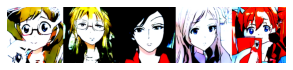

In [225]:
show_image(giant_img[...,0:1270])

In [215]:
giant_img=torch.cat([pred for pred in preds[0][0][0]],dim=2)

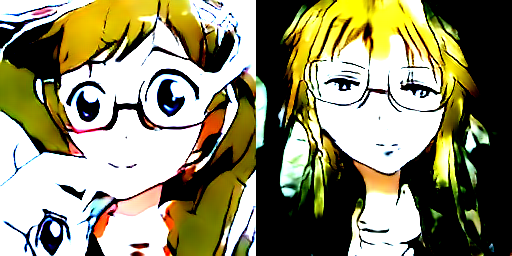

In [246]:
def to_img(x):
    if isinstance(x,Tensor): x = to_np(x.permute((1,2,0)))
    if x.dtype==np.float32: x = (x*255).astype(np.uint8)
    return Image.fromarray(x, mode='RGB')
to_img(giant_img[...,0:512].clamp(0,1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


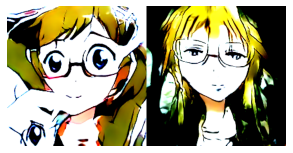

In [232]:
show_image(torch.cat([torch.cat([pred for pred in preds[0][0][0][0:0+2]],dim=2) for i in range(0,10,10)],dim=1))

In [195]:
preds[0][0][0].shape

torch.Size([100, 3, 256, 256])

In [264]:
learner.get_preds()

TypeError: 'module' object is not callable

In [184]:
giant_img=giant_img.view(3,2560,2560)

In [150]:
import torchvision.transforms as torch_transforms

In [249]:
pil=torch_transforms.ToPILImage()(giant_img.clamp(0,1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


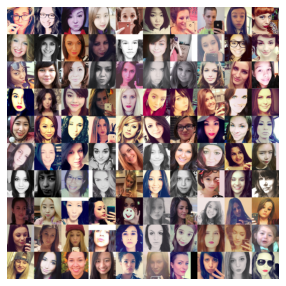

In [259]:
denorm('selfie',giant_img2)

In [263]:
pil=torch_transforms.ToPILImage()(denorm('anime',giant_img).clamp(0,1))
pil.save('big_img13.png')

In [260]:
pil2=torch_transforms.ToPILImage()(denorm('selfie',giant_img2))

In [261]:
pil2.save('big_img11.png')

In [335]:
def file_list_to_dls(selfies,animes):
    tfm=Pipeline([CyclePair(animes), OpenAndResize, IntToFloatTensor(div=False)])
    augmentations=ListofTransformsforTuple([RandomResizedCropGPU(256,min_scale=0.98,)], data_stats)
    tfmDs=Datasets(selfies,[tfm,tfm2])
    dls=tfmDs.dataloaders(bs=1,val_bs=1,after_batch=augmentations, num_workers=0)
    return dls
ex_dls=file_list_to_dls(L([Path('/home/fast/fastai2/anime/nbs/meow.png')]),
                        L([Path('/home/fast/fastai2/anime/nbs/meow.png')]))

torch.Size([3, 256, 512])
torch.Size([1, 1, 2])


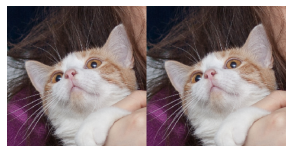

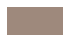

In [336]:
ex_dls.show_batch()

In [284]:
Path().absolute()

Path('/home/fast/fastai2/anime/nbs')

In [294]:
ex_img=Image.open(Path('/home/fast/fastai2/anime/nbs/ex_img.png'))

In [303]:
ex_img=ex_img.crop((200, 50, 853, 1000))

In [304]:
ex_img.save('ex_img.png')

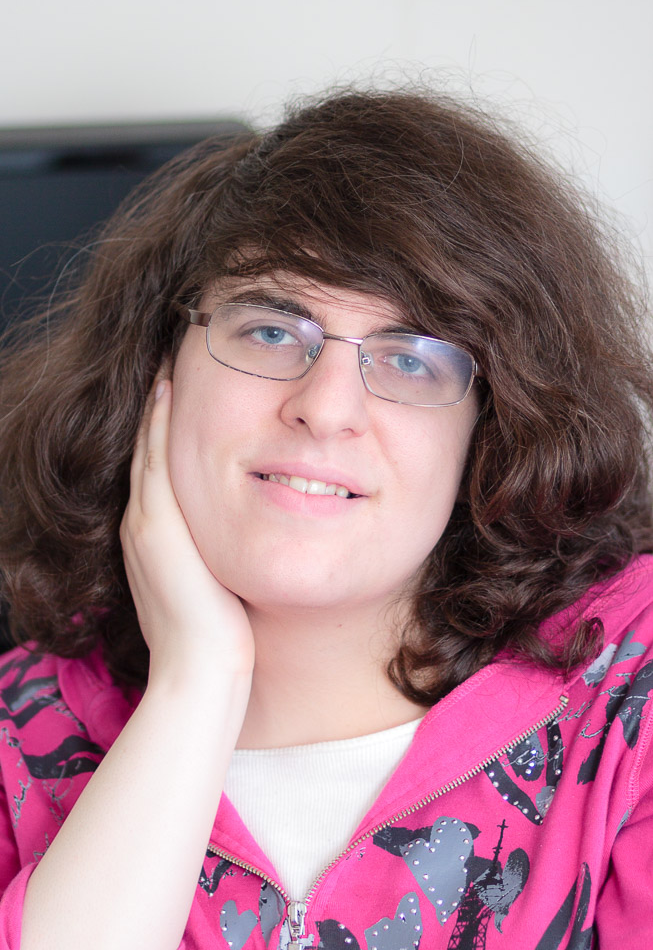

In [307]:
Image.open('ex_img.png')

In [337]:
ex_preds=learner.get_preds(dl=ex_dls.train)

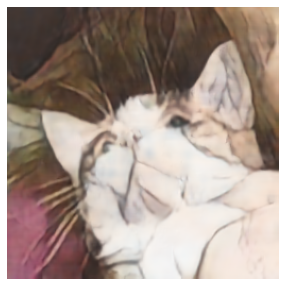

In [338]:
show_image(denorm('anime',ex_preds[0][0][0][0]).clamp(0,1))